# imports 

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, classification_report
)

# Imbalanced data handling
from imblearn.over_sampling import SMOTE

# ML Libraries
import xgboost as xgb
import lightgbm as lgb

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Utilities
import joblib
# Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Data Preparation

## 1. Load the data

In [3]:
df = pd.read_csv("Complaints - Approved Version.csv")

## 2. Display data summary

In [4]:
df.head

<bound method NDFrame.head of                   CASE_ID      OFFER_NAME CUSTOMER_TYPE    CUSTOMER_GROUP  \
0      CAS-1060890-L3D6Q6       FTTH Home           CBU         FTTH Home   
1       CAS-388567-W4B9Q3             NaN           CBU               NaN   
2      CAS-1494939-L9F0X7  Bitstream Home           CBU  Wanadoo-ADSL-Res   
3      CAS-1059985-K3Y9F7       FTTH Home           CBU         FTTH Home   
4      CAS-1239942-Y1S2F5       FTTH Home           CBU         FTTH Home   
...                   ...             ...           ...               ...   
10410   CAS-549162-Y2F4X6  OnLine Prepaid           CBU           Prepaid   
10411  CAS-1094578-B7J7Z0       FTTH Home           CBU         FTTH Home   
10412   CAS-470088-Q3Y2V7  FTTB Corporate           EBU    FTTB Corporate   
10413  CAS-1249800-V2H6C7  Bitstream Home           CBU  Wanadoo-ADSL-Res   
10414   CAS-805076-V0F0N9  Bitstream Home           CBU  Wanadoo-ADSL-Res   

      CURRENT_STATUS ESCALATION_FLAG ESCALATE

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10415 entries, 0 to 10414
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CASE_ID                 10415 non-null  object 
 1   OFFER_NAME              9122 non-null   object 
 2   CUSTOMER_TYPE           10415 non-null  object 
 3   CUSTOMER_GROUP          9067 non-null   object 
 4   CURRENT_STATUS          10415 non-null  object 
 5   ESCALATION_FLAG         10415 non-null  object 
 6   ESCALATED_GROUP         3360 non-null   object 
 7   OPEN_DATE               10415 non-null  object 
 8   CLOSE_DATE              10296 non-null  object 
 9   AGE_BRACKET             10296 non-null  float64
 10  ACTUAL_COMPLAINT        10415 non-null  object 
 11  CALLBACK_MECHANISM      3138 non-null   object 
 12  RESOLUTION              79 non-null     object 
 13  RESOLUTION_DESCRIPTION  39 non-null     object 
 14  CASE_DESC               1172 non-null 

In [6]:
df.describe()

,AGE_BRACKET
count,10296.000000
mean,1.503302
std,2.978144
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,116.000000


## 3. Select target column

In [7]:
target_col = 'COMPLAINT_TYPE'


## 4. Handle missing values

In [8]:
# Fill missing text values with empty string ""
text_cols = ['CASE_DESC', 'RESOLUTION_DESCRIPTION', 'RESOLUTION']
for col in text_cols:
    if col in df.columns:
        df[col] = df[col].fillna('')

# Fill missing numerical values with median
num_cols = df.select_dtypes(include=np.number).columns.tolist()
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

## 5. Create unified text column by combining text columns

In [9]:
df['combined_text'] = df[text_cols].agg(' '.join, axis=1)

## 6. Clean the text

In [10]:
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)  # Remove non-alphabetic characters (keep only a-z and spaces)
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces, keep single spaces
    text = text.strip()  # Remove leading/trailing spaces
    return text

df['cleaned_text'] = df['combined_text'].apply(clean_text)

# Display the first few rows of combined and cleaned text columns
print(df[['combined_text', 'cleaned_text']].head())

  combined_text cleaned_text
0                           
1                           
2                           
3                           
4                           


# Modeling

## 1. Convert text to numerical features using TfidfVectorizer

In [12]:
vectorizer = TfidfVectorizer(max_features=10000)  # limit features to 10k (can adjust)
X = vectorizer.fit_transform(df['cleaned_text'])

## 2. Define target variable

In [13]:
y = df[target_col]

## 3. Split data into train and test sets (80% train, 20% test), stratify by target

In [14]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, stratify=y, random_state=42)

## 4. Define models

In [15]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100),
    'Passive Aggressive': PassiveAggressiveClassifier(max_iter=1000),
    'SVM': SVC(kernel='linear'),
}

## 5. Train, predict, and store results


In [16]:
results = []

for name, model in models.items():
    print(f'Training {name}...')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    print(f'{name} Accuracy: {acc:.4f}')
    print(classification_report(y_test, y_pred))
    
    results.append({
        'Model': name,
        'Accuracy': acc,
    })

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)
print(results_df)

Training Logistic Regression...
Logistic Regression Accuracy: 0.7633
              precision    recall  f1-score   support

  Commercial       0.00      0.00      0.00       493
   Technical       0.76      1.00      0.87      1590

    accuracy                           0.76      2083
   macro avg       0.38      0.50      0.43      2083
weighted avg       0.58      0.76      0.66      2083

Training Random Forest...


C:\Users\yhamdan\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yhamdan\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yhamdan\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

Random Forest Accuracy: 0.7633
              precision    recall  f1-score   support

  Commercial       0.00      0.00      0.00       493
   Technical       0.76      1.00      0.87      1590

    accuracy                           0.76      2083
   macro avg       0.38      0.50      0.43      2083
weighted avg       0.58      0.76      0.66      2083

Training Gradient Boosting...
Gradient Boosting Accuracy: 0.7633
              precision    recall  f1-score   support

  Commercial       0.00      0.00      0.00       493
   Technical       0.76      1.00      0.87      1590

    accuracy                           0.76      2083
   macro avg       0.38      0.50      0.43      2083
weighted avg       0.58      0.76      0.66      2083

Training Passive Aggressive...
Passive Aggressive Accuracy: 0.7633
              precision    recall  f1-score   support

  Commercial       0.00      0.00      0.00       493
   Technical       0.76      1.00      0.87      1590

    accuracy       

C:\Users\yhamdan\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yhamdan\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yhamdan\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

SVM Accuracy: 0.7633
              precision    recall  f1-score   support

  Commercial       0.00      0.00      0.00       493
   Technical       0.76      1.00      0.87      1590

    accuracy                           0.76      2083
   macro avg       0.38      0.50      0.43      2083
weighted avg       0.58      0.76      0.66      2083

                 Model  Accuracy
0  Logistic Regression  0.763322
1        Random Forest  0.763322
2    Gradient Boosting  0.763322
3   Passive Aggressive  0.763322
4                  SVM  0.763322


C:\Users\yhamdan\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yhamdan\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yhamdan\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

In [17]:
print(classification_report(y_test, y_pred, zero_division=0))


              precision    recall  f1-score   support

  Commercial       0.00      0.00      0.00       493
   Technical       0.76      1.00      0.87      1590

    accuracy                           0.76      2083
   macro avg       0.38      0.50      0.43      2083
weighted avg       0.58      0.76      0.66      2083



## SMOTE
I used **SMOTE (Synthetic Minority Over-sampling Technique)** instead of the basic training loop on the original data because our dataset suffers from **class imbalance**. Some classes have much fewer samples than others, which can cause models to be biased towards the majority classes and perform poorly on minority classes.

The original training approach trains models on the imbalanced data as is, which often leads to low recall or precision for underrepresented classes.

SMOTE helps by **creating synthetic samples for the minority classes**, effectively balancing the training data without simply duplicating existing samples. This improves the model's ability to learn patterns for all classes more fairly.

By applying SMOTE before training, the models are exposed to a more balanced dataset, which usually results in better performance on minority classes and reduces warnings about undefined metrics.



In [19]:
# After splitting:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Then train models on X_train_res, y_train_res instead of X_train, y_train
for name, model in models.items():
    print(f'Training {name}...')
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    print(f'{name} Accuracy: {acc:.4f}')
    print(classification_report(y_test, y_pred, zero_division=0))
    
    results.append({
        'Model': name,
        'Accuracy': acc,
    })


Training Logistic Regression...
Logistic Regression Accuracy: 0.6980
              precision    recall  f1-score   support

  Commercial       0.23      0.11      0.15       493
   Technical       0.76      0.88      0.82      1590

    accuracy                           0.70      2083
   macro avg       0.49      0.50      0.48      2083
weighted avg       0.63      0.70      0.66      2083

Training Random Forest...
Random Forest Accuracy: 0.6980
              precision    recall  f1-score   support

  Commercial       0.23      0.11      0.15       493
   Technical       0.76      0.88      0.82      1590

    accuracy                           0.70      2083
   macro avg       0.49      0.50      0.48      2083
weighted avg       0.63      0.70      0.66      2083

Training Gradient Boosting...
Gradient Boosting Accuracy: 0.6980
              precision    recall  f1-score   support

  Commercial       0.23      0.11      0.15       493
   Technical       0.76      0.88      0.82   

# Evaluation

Evaluating Logistic Regression...
Accuracy: 0.6980
Precision: 0.6350
Recall: 0.6980
F1 Score: 0.6589
              precision    recall  f1-score   support

  Commercial       0.23      0.11      0.15       493
   Technical       0.76      0.88      0.82      1590

    accuracy                           0.70      2083
   macro avg       0.49      0.50      0.48      2083
weighted avg       0.63      0.70      0.66      2083



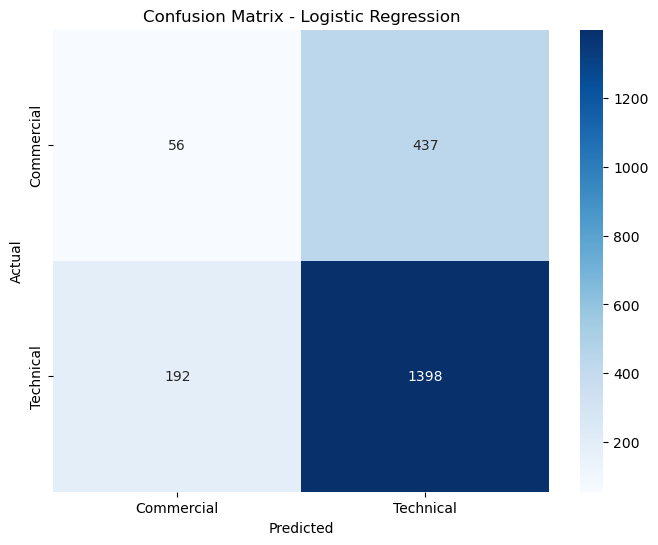

Evaluating Random Forest...
Accuracy: 0.6980
Precision: 0.6350
Recall: 0.6980
F1 Score: 0.6589
              precision    recall  f1-score   support

  Commercial       0.23      0.11      0.15       493
   Technical       0.76      0.88      0.82      1590

    accuracy                           0.70      2083
   macro avg       0.49      0.50      0.48      2083
weighted avg       0.63      0.70      0.66      2083



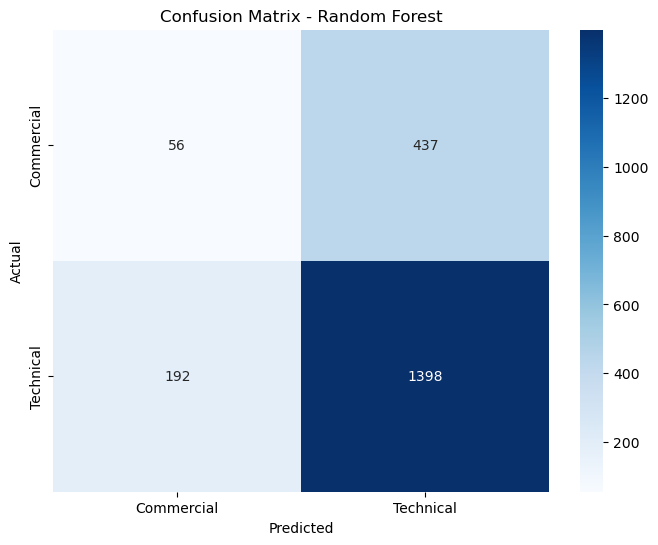

Evaluating Gradient Boosting...
Accuracy: 0.6980
Precision: 0.6350
Recall: 0.6980
F1 Score: 0.6589
              precision    recall  f1-score   support

  Commercial       0.23      0.11      0.15       493
   Technical       0.76      0.88      0.82      1590

    accuracy                           0.70      2083
   macro avg       0.49      0.50      0.48      2083
weighted avg       0.63      0.70      0.66      2083



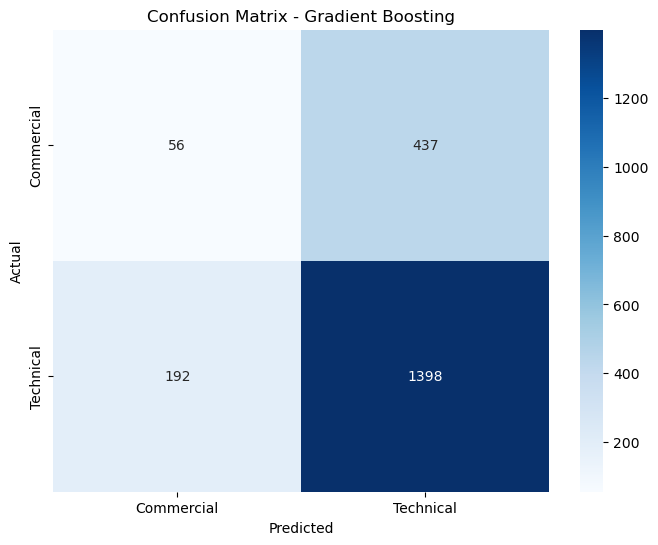

Evaluating Passive Aggressive...
Accuracy: 0.2372
Precision: 0.8194
Recall: 0.2372
F1 Score: 0.0916
              precision    recall  f1-score   support

  Commercial       0.24      1.00      0.38       493
   Technical       1.00      0.00      0.00      1590

    accuracy                           0.24      2083
   macro avg       0.62      0.50      0.19      2083
weighted avg       0.82      0.24      0.09      2083



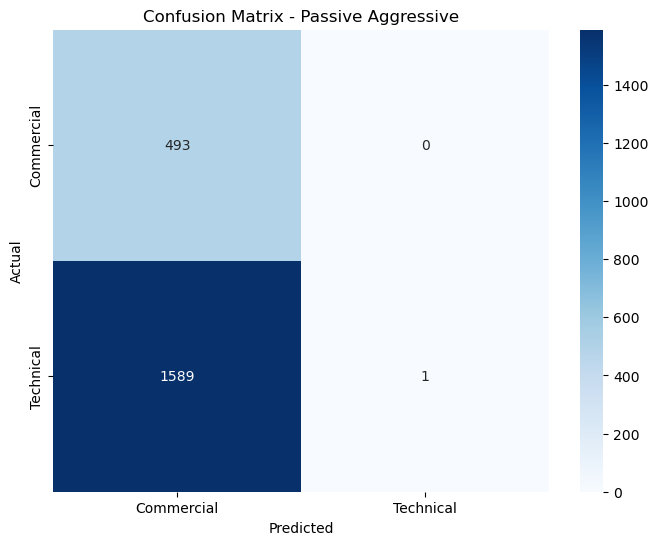

Evaluating SVM...
Accuracy: 0.6980
Precision: 0.6350
Recall: 0.6980
F1 Score: 0.6589
              precision    recall  f1-score   support

  Commercial       0.23      0.11      0.15       493
   Technical       0.76      0.88      0.82      1590

    accuracy                           0.70      2083
   macro avg       0.49      0.50      0.48      2083
weighted avg       0.63      0.70      0.66      2083



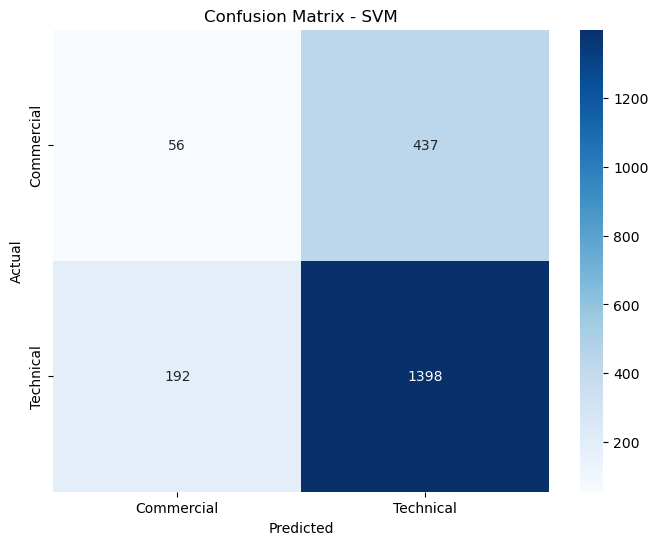

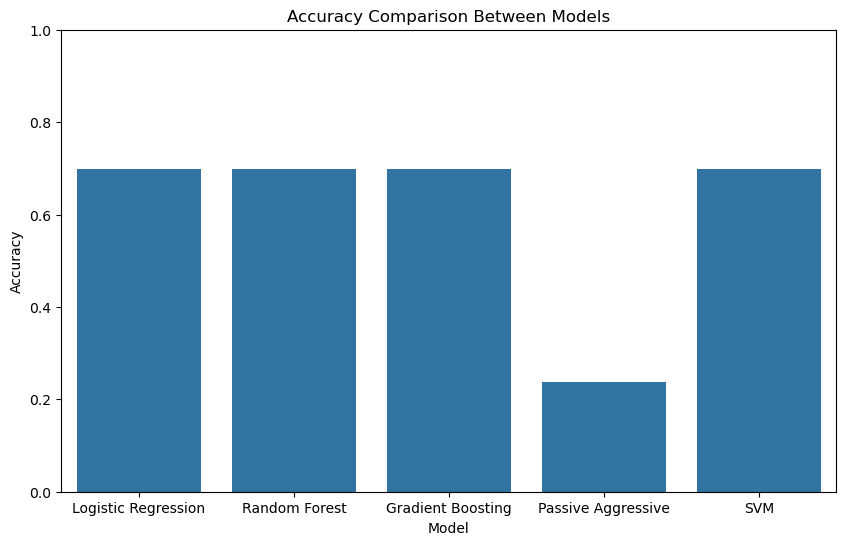

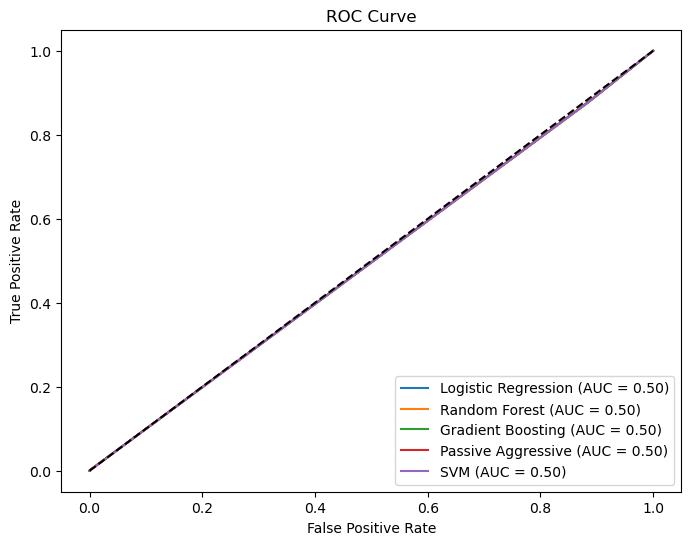

['tfidf_vectorizer.pkl']

In [21]:
# Encode y_test to numeric labels for ROC curve and other uses
le = LabelEncoder()
y_test_encoded = le.fit_transform(y_test)  # e.g. 'Commercial'->0, 'Technical'->1

results = []

for name, model in models.items():
    print(f"Evaluating {name}...")
    y_pred = model.predict(X_test)
    
    # Calculate metrics (using original string labels)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    # Confusion matrix heatmap
    cm = confusion_matrix(y_test, y_pred, labels=le.classes_)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Save the model
    joblib.dump(model, f"{name.replace(' ', '_').lower()}_model.pkl")
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    })

# Accuracy comparison bar chart
results_df = pd.DataFrame(results)
plt.figure(figsize=(10,6))
sns.barplot(data=results_df, x='Model', y='Accuracy')
plt.title('Accuracy Comparison Between Models')
plt.ylim(0,1)
plt.show()

# ROC Curve (only for binary classification)
if len(le.classes_) == 2:
    plt.figure(figsize=(8,6))
    for name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)[:,1]  # probability for positive class (encoded 1)
        else:
            # Some models like SVM may not have predict_proba by default
            y_prob = model.decision_function(X_test)
            # Scale to [0,1]
            y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())
        fpr, tpr, _ = roc_curve(y_test_encoded, y_prob, pos_label=1)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

# Save the vectorizer
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')


In [22]:
print(df[target_col].value_counts(normalize=True))


COMPLAINT_TYPE
Technical     0.763514
Commercial    0.236486
Name: proportion, dtype: float64


# Recommendations

## 1. Adjust Class Weights in Models

In [23]:
# Logistic Regression with class weight balancing
log_reg = LogisticRegression(class_weight='balanced', random_state=42)
log_reg.fit(X_train, y_train)

# SVM with class weight balancing
svm_model = SVC(class_weight='balanced', random_state=42)
svm_model.fit(X_train, y_train)

SVC(class_weight='balanced', random_state=42)

## 2. Test XGBoost

In [27]:
from sklearn.preprocessing import LabelEncoder

# Encode target labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Calculate scale_pos_weight for imbalance handling
pos_weight = (len(y_train_enc) - sum(y_train_enc)) / sum(y_train_enc)

# XGBoost with class imbalance handling
xgb_model = xgb.XGBClassifier(eval_metric='logloss', scale_pos_weight=pos_weight)
xgb_model.fit(X_train, y_train_enc)

print("XGBoost Report:")
print(classification_report(y_test_enc, xgb_model.predict(X_test)))


XGBoost Report:
              precision    recall  f1-score   support

           0       0.23      0.11      0.15       493
           1       0.76      0.88      0.82      1590

    accuracy                           0.70      2083
   macro avg       0.49      0.50      0.48      2083
weighted avg       0.63      0.70      0.66      2083



## 3. Advanced Text Preprocessing

In [30]:
nltk.download('stopwords')
nltk.download('wordnet')
# Clean column names (remove leading/trailing spaces)
df.columns = df.columns.str.strip()

# Detect the complaint text column automatically
possible_columns = [col for col in df.columns if 'complain' in col.lower() or 'case' in col.lower()]
if not possible_columns:
    raise ValueError("No complaint text column found. Please check your CSV.")
text_column = possible_columns[0]
print(f"Using text column: {text_column}")

# Initialize preprocessing tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define advanced cleaning function
def clean_text(text):
    text = str(text).lower()                        # Lowercase
    text = re.sub(r'[^a-z\s]', '', text)            # Remove punctuation & numbers
    words = text.split()                            # Tokenize
    words = [w for w in words if w not in stop_words] # Remove stopwords
    words = [lemmatizer.lemmatize(w) for w in words] # Lemmatize
    return ' '.join(words)

# Apply preprocessing
df['CLEAN_COMPLAINT'] = df[text_column].apply(clean_text)

# Preview cleaned data
print(df[['CLEAN_COMPLAINT']].head())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yhamdan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yhamdan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Using text column: CASE_ID
  CLEAN_COMPLAINT
0          casldq
1          caswbq
2          caslfx
3          caskyf
4          casysf


In [32]:
before_vocab = Counter(" ".join(df[text_column].astype(str)).split())
after_vocab = Counter(" ".join(df['CLEAN_COMPLAINT']).split())

print(f"Unique words before: {len(before_vocab)}")
print(f"Unique words after: {len(after_vocab)}")

Unique words before: 10379
Unique words after: 6247


## 4. Use Deep Learning Models (Example)

In [35]:
label_col = 'COMPLAINT_TYPE'  

le = LabelEncoder()

df['COMPLAINT_TYPE_ENCODED'] = le.fit_transform(df[label_col])

X_train, X_test, y_train, y_test = train_test_split(
    X_pad,
    df['COMPLAINT_TYPE_ENCODED'],
    test_size=0.2,
    random_state=42
)


In [36]:
# Tokenization
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['CLEAN_COMPLAINT'])
X_seq = tokenizer.texts_to_sequences(df['CLEAN_COMPLAINT'])
X_pad = pad_sequences(X_seq, maxlen=100)

# Train/Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pad, df['COMPLAINT_TYPE_ENCODED'], test_size=0.2, random_state=42)

# LSTM Model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=100))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/5


C:\Users\yhamdan\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


261/261 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.7642 - loss: 0.5494 - val_accuracy: 0.7590 - val_loss: 0.5536
Epoch 2/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.7634 - loss: 0.4821 - val_accuracy: 0.6956 - val_loss: 0.6256
Epoch 3/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.8243 - loss: 0.3492 - val_accuracy: 0.6894 - val_loss: 0.7382
Epoch 4/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.8261 - loss: 0.3039 - val_accuracy: 0.5266 - val_loss: 0.8748
Epoch 5/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.8272 - loss: 0.2880 - val_accuracy: 0.6639 - val_loss: 0.9261
